# FOREX Price Prediction with LSTM model

In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import time
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from scipy.stats import spearmanr

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

import yfinance as yf

plt.style.use('seaborn-v0_8-whitegrid')

## Data Load

In [2]:
raw_data = yf.download(tickers='EURUSD=X', start='2011-12-31', end='2019-12-31', interval='1d')
raw_data.columns = raw_data.columns.droplevel(1)
raw_data

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2012-01-02,1.296008,1.296395,1.292257,1.296008,0
2012-01-03,1.294096,1.306592,1.293628,1.293628,0
2012-01-04,1.305602,1.307395,1.290206,1.305398,0
2012-01-05,1.293142,1.294297,1.278527,1.293092,0
2012-01-06,1.279607,1.281296,1.270406,1.279296,0
...,...,...,...,...,...
2019-12-24,1.109385,1.109755,1.107064,1.109299,0
2019-12-25,1.109016,1.110864,1.107788,1.109139,0
2019-12-26,1.109545,1.110494,1.108279,1.109509,0


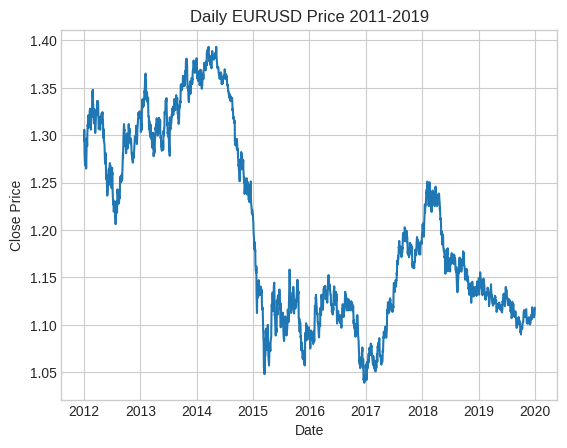

In [3]:
plt.plot(raw_data.index, raw_data.Close)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Daily EURUSD Price 2011-2019')
plt.show()

## Implement class and function

In [4]:
class Utils:

  @staticmethod
  def data_split(data, train_size = 0.7):
    '''
    Split dataset into train_data and val_data

    Prameters:
    - data (pd.Dataframe) : input dataframe
    - train_size (float): The ratio of train dataset. Default is 0.7

    Return:
    - train_data: train dataframe
    - val_data: validation dataframe

    '''
    train_data = data[:math.ceil(len(data)*train_size)]
    val_data = data[math.ceil(len(data)*train_size):]

    return train_data, val_data

  @staticmethod
  def data_scaling(data, scaler=MinMaxScaler(feature_range=(-1,1)), train=True):
    '''
    Feature scaling transforms feature values to a similar scale, ensuring all features contribute equally to the model.

    Parameters:
    - data (pd.Dataframe): array-like of shape (n_samples, n_features)
    - scaler (ojb): scikit-learn scaler. Default is MinMaxScaler(feature_range=(-1,1)))

    Return:
    - scaled_data (np.array): scaled data
    - scaler (ojb): scaler object
    '''
    if train:
      scaled_data = scaler.fit_transform(data)

    else:
      scaled_data = scaler.transform(data)

    return scaled_data, scaler


  @staticmethod
  def prepare_sequence_input_target(data, look_back):
    '''
    Prepare input sequences and corresponding target values.

    This function creates input sequences of a specified window size and their corresponding target values.

    Parameters:
    - data (np.array): array-like of shape (n_samples, n_features)
    - look_back (int): The length of input sequences.

    Return:
    - X_train (np.array): Input sequences of shape (n_samples, look_back, n_features)
    - y_train (np.array): Target values of shape (n_samples, n_features)
    '''
    X_train, y_train = [], []
    for i in range(look_back, len(data)):
      X_train.append(data[i-look_back:i,:])
      y_train.append(data[i,:])

    return np.array(X_train), np.array(y_train)


def process_sequence_data(data, look_back, scaler, train):

    scaled_data, scaler  = Utils.data_scaling(data, scaler, train)
    X, y = Utils.prepare_sequence_input_target(scaled_data, look_back)
    dataset = MyDataset(X, y)

    return dataset, scaler


In [5]:
class MyDataset(Dataset):

  def __init__(self, X, y):
    self.X = torch.tensor(X, dtype=torch.float32)
    self.y = torch.tensor(y, dtype=torch.float32)

  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    X = self.X[idx]
    y = self.y[idx]

    return X, y

In [6]:
class LSTM(nn.Module):
  def __init__(self, input_size=1, hidden_size=32, num_layers=1, output_size=1, dropout=0):
    super().__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):

    output, self.hidden_cell = self.lstm(x)
    predictions = self.fc(output[:,-1,:]) # [batch_size, output_size]

    return predictions[:, 0]

In [7]:
def train(model, train_loader, val_loader, optimizer, criterion, epochs, model_save_path):
  train_loss_log = {}
  val_loss_log = {}
  best_val_loss = np.inf

  for epoch in range(1, epochs+1):

    # model training
    model.train()
    train_loss = 0
    for batch, data in tqdm(enumerate(train_loader), total=len(train_loader), desc="Training", leave=False):
      X, y = data
      X = X.to(device)
      y = y.to(device)

      optimizer.zero_grad()

      # y_pred = model(X).view(1,1)
      y_pred = model(X)
      loss = criterion(y_pred, y)

      # import pdb; pdb.set_trace()

      loss.backward()
      optimizer.step()

      train_loss += loss.item()

    # model validation
    model.eval()
    val_loss = 0

    for batch, data in tqdm(enumerate(val_loader), total=len(val_loader), desc="Validation", leave=False):
      X_val, y_val = data
      X_val = X_val.to(device)
      y_val = y_val.to(device)


      # y_val_pred = model(X_val).view(1,1)
      y_val_pred = model(X_val)
      loss = criterion(y_val_pred, y_val)

      val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_loss_log[epoch] = avg_train_loss
    avg_val_loss = val_loss / len(val_loader)
    val_loss_log[epoch] = avg_val_loss
    print(f'Epoch: {epoch}/{epochs}, Train loss: {avg_train_loss: .6f}, Val Loss: {avg_val_loss:.6f}')

    # import pdb; pdb.set_trace()

    if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss

      # save model
      torch.save(model.state_dict(), f'{model_save_path}/lstm_{epoch}.pth')
      print(f'Model saved with validation loss: {best_val_loss:.6f}')

    print('-'*60)

  return train_loss_log, val_loss_log

## Learning

In [8]:
# data set
train_size = 0.7

# data split
data = raw_data[['Close']]
train_data, val_data = Utils.data_split(data, train_size)

# hyperparameters
look_back = 30
scaler = MinMaxScaler(feature_range=(-1,1))
batch_size = 1
epochs = 30
input_size = 1
hidden_size = 62
num_layers = 1
dropout = 0
model_save_path = '.'

# data processing
train_dataset, scaler = process_sequence_data(train_data, look_back=look_back, scaler=scaler, train=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataset, scaler = process_sequence_data(val_data, look_back=look_back, scaler=scaler, train=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


model = LSTM(input_size=input_size, hidden_size= hidden_size, num_layers= num_layers, dropout=dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

start_time = time.time()
train_loss_log, val_loss_log = train(model, train_loader, val_loader, optimizer, criterion, epochs, model_save_path=model_save_path)
end_time = time.time()

print('')
print(f'Time to complete {end_time-start_time:.2f} sec')

Training:   0%|          | 0/1427 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1/30, Train loss:  0.009747, Val Loss: 0.045795
Model saved with validation loss: 0.045795
------------------------------------------------------------


Epoch: 2/30, Train loss:  0.012452, Val Loss: 0.040949
Model saved with validation loss: 0.040949
------------------------------------------------------------


Epoch: 3/30, Train loss:  0.010825, Val Loss: 0.030125
Model saved with validation loss: 0.030125
------------------------------------------------------------


Epoch: 4/30, Train loss:  0.006786, Val Loss: 0.019933
Model saved with validation loss: 0.019933
------------------------------------------------------------


Epoch: 5/30, Train loss:  0.004677, Val Loss: 0.017765
Model saved with validation loss: 0.017765
------------------------------------------------------------


Epoch: 6/30, Train loss:  0.003703, Val Loss: 0.016580
Model saved with validation loss: 0.016580
------------------------------------------------------------


Epoch: 7/30, Train loss:  0.002975, Val Loss: 0.015927
Model saved with validation loss: 0.015927
------------------------------------------------------------


Epoch: 8/30, Train loss:  0.002983, Val Loss: 0.015412
Model saved with validation loss: 0.015412
------------------------------------------------------------


Epoch: 9/30, Train loss:  0.002679, Val Loss: 0.014285
Model saved with validation loss: 0.014285
------------------------------------------------------------


Epoch: 10/30, Train loss:  0.002321, Val Loss: 0.014400
------------------------------------------------------------


Epoch: 11/30, Train loss:  0.002300, Val Loss: 0.016335
------------------------------------------------------------


Epoch: 12/30, Train loss:  0.002244, Val Loss: 0.014439
------------------------------------------------------------


Epoch: 13/30, Train loss:  0.002050, Val Loss: 0.012142
Model saved with validation loss: 0.012142
------------------------------------------------------------


Epoch: 14/30, Train loss:  0.002002, Val Loss: 0.014654
------------------------------------------------------------


Epoch: 15/30, Train loss:  0.001900, Val Loss: 0.017956
------------------------------------------------------------


Epoch: 16/30, Train loss:  0.002082, Val Loss: 0.014962
------------------------------------------------------------


Epoch: 17/30, Train loss:  0.002426, Val Loss: 0.011599
Model saved with validation loss: 0.011599
------------------------------------------------------------


Epoch: 18/30, Train loss:  0.001884, Val Loss: 0.018003
------------------------------------------------------------


Epoch: 19/30, Train loss:  0.002125, Val Loss: 0.009312
Model saved with validation loss: 0.009312
------------------------------------------------------------


Epoch: 20/30, Train loss:  0.001890, Val Loss: 0.001735
Model saved with validation loss: 0.001735
------------------------------------------------------------


Epoch: 21/30, Train loss:  0.002100, Val Loss: 0.006451
------------------------------------------------------------


Epoch: 22/30, Train loss:  0.002643, Val Loss: 0.008899
------------------------------------------------------------


Epoch: 23/30, Train loss:  0.002514, Val Loss: 0.006608
------------------------------------------------------------


Epoch: 24/30, Train loss:  0.003184, Val Loss: 0.012608
------------------------------------------------------------


Epoch: 25/30, Train loss:  0.002817, Val Loss: 0.009995
------------------------------------------------------------


Epoch: 26/30, Train loss:  0.002160, Val Loss: 0.011125
------------------------------------------------------------


Epoch: 27/30, Train loss:  0.002135, Val Loss: 0.009590
------------------------------------------------------------


Epoch: 28/30, Train loss:  0.002132, Val Loss: 0.012587
------------------------------------------------------------


Epoch: 29/30, Train loss:  0.002181, Val Loss: 0.007373
------------------------------------------------------------


Epoch: 30/30, Train loss:  0.002071, Val Loss: 0.012353
------------------------------------------------------------

Time to complete 135.72 sec


## Model Performance

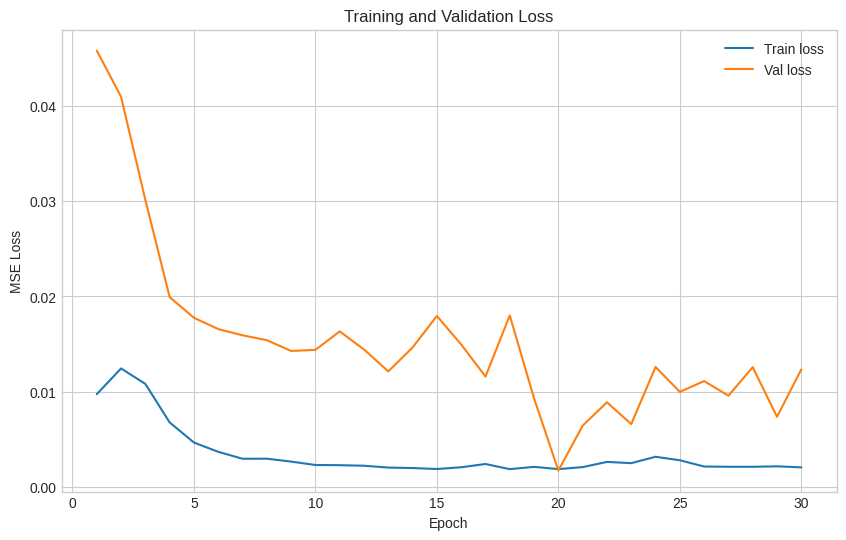

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(list(train_loss_log.keys()), list(train_loss_log.values()), label='Train loss')
plt.plot(list(val_loss_log.keys()), list(val_loss_log.values()), label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Load Model

In [10]:
best_model = min(val_loss_log, key=val_loss_log.get)
model.load_state_dict(torch.load(f'{model_save_path}/lstm_{best_model}.pth', map_location=torch.device(device)))

<All keys matched successfully>

## Estimation

In [11]:
test_data = yf.download(tickers='EURUSD=X', start='2020-01-01', end='2023-12-31', interval='1d')
test_data.columns = test_data.columns.droplevel(1)
test_data = test_data[['Close']]
test_data

[*********************100%***********************]  1 of 1 completed


Price,Close
Date,
2020-01-01,1.122083
2020-01-02,1.122083
2020-01-03,1.117144
2020-01-06,1.116196
2020-01-07,1.119799
...,...
2023-12-25,1.102657
2023-12-26,1.102026
2023-12-27,1.104301


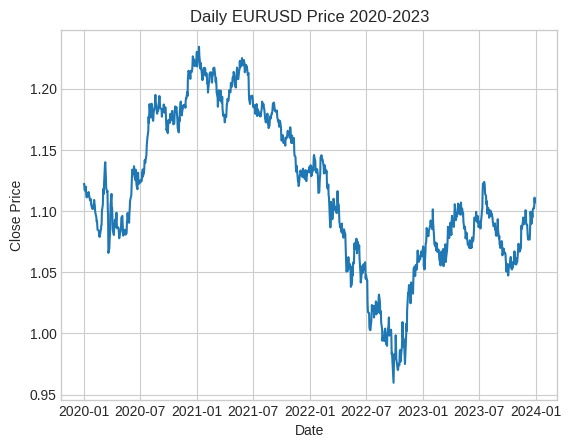

In [12]:
plt.plot(test_data.index, test_data.Close)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Daily EURUSD Price 2020-2023')
plt.show()

In [13]:
test_dataset, scaler = process_sequence_data(test_data, look_back=look_back, scaler=scaler, train=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [14]:
# make predictions
y_pred_log = []
y_log = []

model.eval()
for batch, data in enumerate(test_loader):
  X_test, y_test = data
  X_test = X_test.to(device)
  y_test = y_test.to(device)

  y_test_pred = model(X_test)
  y_test_pred = y_test_pred.view(-1,1)
  # import pdb; pdb.set_trace()
  loss = criterion(y_test_pred, y_test)

  # invert predictions
  y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy()).item()
  y_test = scaler.inverse_transform(y_test.detach().numpy()).item()

  y_pred_log.append(y_test_pred)
  y_log.append(y_test)

In [15]:
# compute root mean squared error, mean_absolute_error
test_rmse = math.sqrt(mean_squared_error(y_log, y_pred_log))
print(f'Test Root Mean Squared Error: {test_rmse:.4f}')
test_mae = mean_absolute_error(y_log, y_pred_log)
print(f'Test Mean Absolute Error: {test_mae: .4f}')

Test Root Mean Squared Error: 0.0259
Test Mean Absolute Error:  0.0188


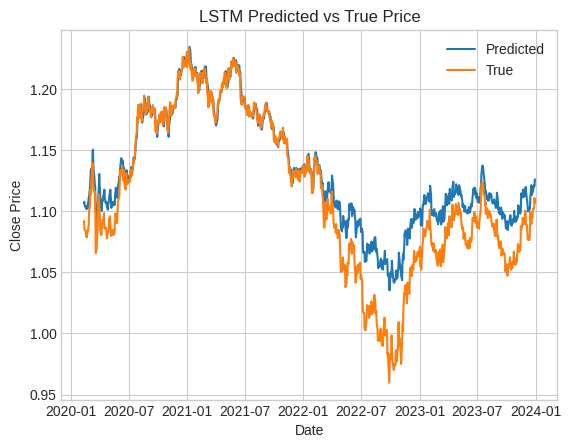

In [16]:
plt.plot(test_data.index[look_back:], y_pred_log, label='Predicted')
plt.plot(test_data.index[look_back:], y_log, label='True')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('LSTM Predicted vs True Price')
plt.legend()
plt.show()

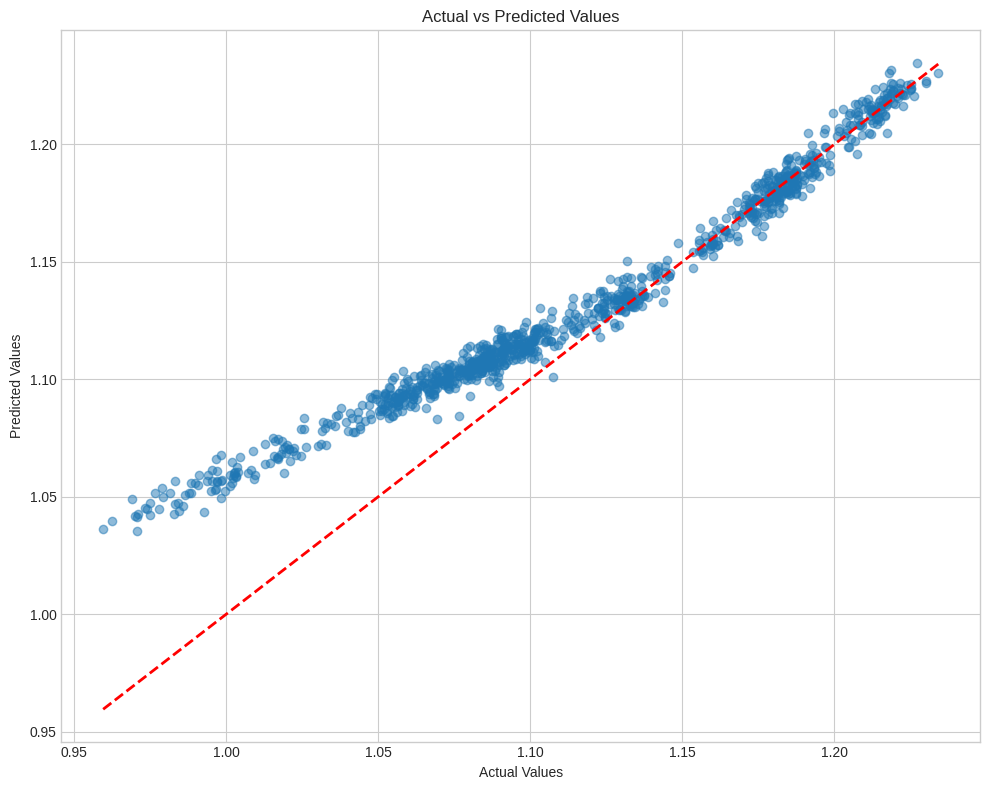

In [17]:
y_pred = np.array(y_pred_log)
y_actual = np.array(y_log)

# Create a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(y_actual, y_pred, alpha=0.5)
plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.tight_layout()
plt.show()


In [18]:
val_ic = spearmanr(y_actual, y_pred)[0]
print(f'Val IC: {val_ic:.4f}')

Val IC: 0.9909


# LSTM model with two feature inputs

The EURUSD daily close price is not sufficient to predict price movement. Now try to build a model with two features (EURUSD and S&P500 daily close price)

In [19]:
tickers = {'ticker_name': ['EURUSD', 'S&P500'],
           'ticker': ['EURUSD=X', '^SPX']}

price_datasets = yf.download(tickers=tickers['ticker'], start='2011-12-31', end='2019-12-31', interval='1d')
df_price = price_datasets[['Close']]
df_price.columns = df_price.columns.droplevel(1)
df_price.columns = tickers['ticker_name']
df_price.head()

[*********************100%***********************]  2 of 2 completed


,EURUSD,S&P500
Date,,
2012-01-02,1.296008,NaN
2012-01-03,1.294096,1277.060059
2012-01-04,1.305602,1277.300049
2012-01-05,1.293142,1281.060059
2012-01-06,1.279607,1277.810059


In [20]:
# nan handling
df_price.isna().sum()

,0
EURUSD,5
S&P500,75


In [21]:
# fill na values with the last valid obsrvation
df_price.ffill(inplace=True)
# remove the first row where no valid observation is available to fill
df_price = df_price.iloc[1:,:]
df_price.head()

<ipython-input-21-72bd1767c812>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_price.ffill(inplace=True)


,EURUSD,S&P500
Date,,
2012-01-03,1.294096,1277.060059
2012-01-04,1.305602,1277.300049
2012-01-05,1.293142,1281.060059
2012-01-06,1.279607,1277.810059
2012-01-09,1.268038,1280.699951


In [22]:
df_price[df_price.isna().any(axis=1)]

,EURUSD,S&P500
Date,,


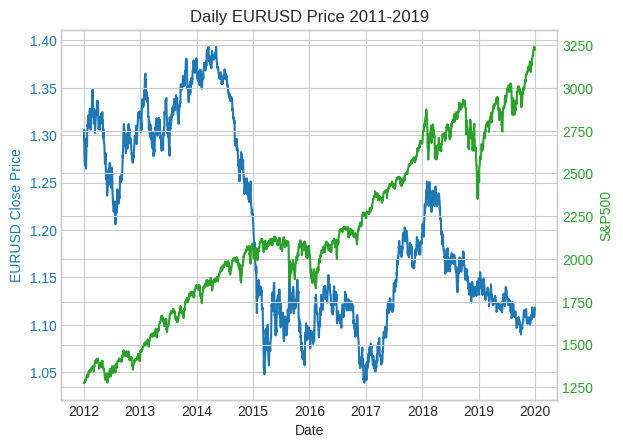

In [23]:
fig, ax1 = plt.subplots()

ax1.plot(df_price.index, df_price.EURUSD, 'tab:blue', label='EURUSD')
ax1.set_xlabel('Date')
ax1.set_ylabel('EURUSD Close Price', color='tab:blue')
ax1.tick_params('y', colors='tab:blue')

ax2 = ax1.twinx()

ax2.plot(df_price.index, df_price['S&P500'], 'tab:green', label='S&P500')
ax2.set_ylabel('S&P500', color='tab:green')
ax2.tick_params('y', colors='tab:green')

plt.title('Daily EURUSD Price 2011-2019')
plt.show()

train_loss has not change while val loss lower and lower -> overfitting??

* dropout
* reduce hidden_layer -> 32
* reduce learning rate -> 0.0001
* add weight_decay

In [24]:
def train_two_features(model, train_loader, val_loader, optimizer, criterion, epochs, model_save_path):
  train_loss_log = {}
  val_loss_log = {}
  best_val_loss = np.inf

  for epoch in range(1, epochs+1):

    # model training
    model.train()
    train_loss = 0
    for batch, data in tqdm(enumerate(train_loader), total=len(train_loader), desc="Training", leave=False):
      X, y = data
      X = X.to(device)
      y = y.to(device)

      optimizer.zero_grad()

      y_pred = model(X)
      loss = criterion(y_pred, y[:,0]) # yl[1,2] -> [1,1] only eur value for loss

      loss.backward()
      optimizer.step()

      train_loss += loss.item()

    # model validation
    model.eval()
    val_loss = 0

    for batch, data in tqdm(enumerate(val_loader), total=len(val_loader), desc="Validation", leave=False):
      X_val, y_val = data
      X_val = X_val.to(device)
      y_val = y_val.to(device)

      y_val_pred = model(X_val)
      loss = criterion(y_val_pred, y_val[:,0]) # y_val[1,2] -> [1,1] only eur value for loss

      val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_loss_log[epoch] = avg_train_loss
    avg_val_loss = val_loss / len(val_loader)
    val_loss_log[epoch] = avg_val_loss
    print(f'Epoch: {epoch}/{epochs}, Train loss: {avg_train_loss: .6f}, Val Loss: {avg_val_loss:.6f}')

    # import pdb; pdb.set_trace()

    if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss

      # save model
      torch.save(model.state_dict(), f'{model_save_path}/lstm_two_feature_model_{epoch}.pth')
      print(f'Model saved with validation loss: {best_val_loss:.6f}')

    print('-'*60)

  return train_loss_log, val_loss_log

In [25]:
# data set
train_size = 0.7

# data split

train_data, val_data = Utils.data_split(df_price, train_size)

# hyperparameters
look_back = 30
scaler = MinMaxScaler(feature_range=(-1,1))
batch_size = 1

learning_rate = 0.0005

epochs = 50
input_size = 2
hidden_size = 32
num_layers = 1
output_size = 1
dropout = 0
model_save_path = '.'

# data processing
train_dataset, scaler = process_sequence_data(train_data, look_back=look_back, scaler=scaler, train=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataset, scaler = process_sequence_data(val_data, look_back=look_back, scaler=scaler, train=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = LSTM(input_size=input_size, hidden_size= hidden_size, num_layers= num_layers, output_size= output_size, dropout=dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

start_time = time.time()
train_loss_log, val_loss_log = train_two_features(model, train_loader, val_loader, optimizer, criterion, epochs, model_save_path=model_save_path)
end_time = time.time()

print('')
print(f'Time to complete {end_time-start_time:.2f} sec')

Epoch: 1/50, Train loss:  0.014322, Val Loss: 0.043000
Model saved with validation loss: 0.043000
------------------------------------------------------------


Epoch: 2/50, Train loss:  0.008359, Val Loss: 0.042486
Model saved with validation loss: 0.042486
------------------------------------------------------------


Epoch: 3/50, Train loss:  0.006932, Val Loss: 0.042354
Model saved with validation loss: 0.042354
------------------------------------------------------------


Epoch: 4/50, Train loss:  0.006684, Val Loss: 0.041031
Model saved with validation loss: 0.041031
------------------------------------------------------------


Epoch: 5/50, Train loss:  0.006014, Val Loss: 0.039962
Model saved with validation loss: 0.039962
------------------------------------------------------------


Epoch: 6/50, Train loss:  0.005248, Val Loss: 0.040210
------------------------------------------------------------


Epoch: 7/50, Train loss:  0.004282, Val Loss: 0.042480
------------------------------------------------------------


Epoch: 8/50, Train loss:  0.003365, Val Loss: 0.046767
------------------------------------------------------------


Epoch: 9/50, Train loss:  0.002625, Val Loss: 0.050681
------------------------------------------------------------


Epoch: 10/50, Train loss:  0.002154, Val Loss: 0.046394
------------------------------------------------------------


Epoch: 11/50, Train loss:  0.001965, Val Loss: 0.039458
Model saved with validation loss: 0.039458
------------------------------------------------------------


Epoch: 12/50, Train loss:  0.001870, Val Loss: 0.033357
Model saved with validation loss: 0.033357
------------------------------------------------------------


Epoch: 13/50, Train loss:  0.001780, Val Loss: 0.027976
Model saved with validation loss: 0.027976
------------------------------------------------------------


Epoch: 14/50, Train loss:  0.001730, Val Loss: 0.019979
Model saved with validation loss: 0.019979
------------------------------------------------------------


Epoch: 15/50, Train loss:  0.001678, Val Loss: 0.012119
Model saved with validation loss: 0.012119
------------------------------------------------------------


Epoch: 16/50, Train loss:  0.001632, Val Loss: 0.009173
Model saved with validation loss: 0.009173
------------------------------------------------------------


Epoch: 17/50, Train loss:  0.001580, Val Loss: 0.003965
Model saved with validation loss: 0.003965
------------------------------------------------------------


Epoch: 18/50, Train loss:  0.001593, Val Loss: 0.013960
------------------------------------------------------------


Epoch: 19/50, Train loss:  0.001590, Val Loss: 0.014993
------------------------------------------------------------


Epoch: 20/50, Train loss:  0.001568, Val Loss: 0.011186
------------------------------------------------------------


Epoch: 21/50, Train loss:  0.001543, Val Loss: 0.008222
------------------------------------------------------------


Epoch: 22/50, Train loss:  0.001557, Val Loss: 0.008799
------------------------------------------------------------


Epoch: 23/50, Train loss:  0.001524, Val Loss: 0.007848
------------------------------------------------------------


Epoch: 24/50, Train loss:  0.001547, Val Loss: 0.005813
------------------------------------------------------------


Epoch: 25/50, Train loss:  0.001616, Val Loss: 0.009561
------------------------------------------------------------


Epoch: 26/50, Train loss:  0.001562, Val Loss: 0.005230
------------------------------------------------------------


Epoch: 27/50, Train loss:  0.001748, Val Loss: 0.015194
------------------------------------------------------------


Epoch: 28/50, Train loss:  0.001659, Val Loss: 0.005477
------------------------------------------------------------


Epoch: 29/50, Train loss:  0.001759, Val Loss: 0.013037
------------------------------------------------------------


Epoch: 30/50, Train loss:  0.001647, Val Loss: 0.011867
------------------------------------------------------------


Epoch: 31/50, Train loss:  0.001631, Val Loss: 0.023443
------------------------------------------------------------


Epoch: 32/50, Train loss:  0.001663, Val Loss: 0.005034
------------------------------------------------------------


Epoch: 33/50, Train loss:  0.001629, Val Loss: 0.020716
------------------------------------------------------------


Epoch: 34/50, Train loss:  0.001632, Val Loss: 0.017411
------------------------------------------------------------


Epoch: 35/50, Train loss:  0.001690, Val Loss: 0.008578
------------------------------------------------------------


Epoch: 36/50, Train loss:  0.001682, Val Loss: 0.027652
------------------------------------------------------------


Epoch: 37/50, Train loss:  0.001652, Val Loss: 0.006739
------------------------------------------------------------


Epoch: 38/50, Train loss:  0.001644, Val Loss: 0.014845
------------------------------------------------------------


Epoch: 39/50, Train loss:  0.001662, Val Loss: 0.037124
------------------------------------------------------------


Epoch: 40/50, Train loss:  0.001588, Val Loss: 0.017921
------------------------------------------------------------


Epoch: 41/50, Train loss:  0.001648, Val Loss: 0.014200
------------------------------------------------------------


Epoch: 42/50, Train loss:  0.001641, Val Loss: 0.012832
------------------------------------------------------------


Epoch: 43/50, Train loss:  0.001683, Val Loss: 0.045090
------------------------------------------------------------


Epoch: 44/50, Train loss:  0.001599, Val Loss: 0.028722
------------------------------------------------------------


Epoch: 45/50, Train loss:  0.001745, Val Loss: 0.010066
------------------------------------------------------------


Epoch: 46/50, Train loss:  0.001604, Val Loss: 0.068897
------------------------------------------------------------


Epoch: 47/50, Train loss:  0.001647, Val Loss: 0.075635
------------------------------------------------------------


Epoch: 48/50, Train loss:  0.001728, Val Loss: 0.063365
------------------------------------------------------------


Epoch: 49/50, Train loss:  0.001671, Val Loss: 0.062700
------------------------------------------------------------


Epoch: 50/50, Train loss:  0.001697, Val Loss: 0.050873
------------------------------------------------------------

Time to complete 191.34 sec


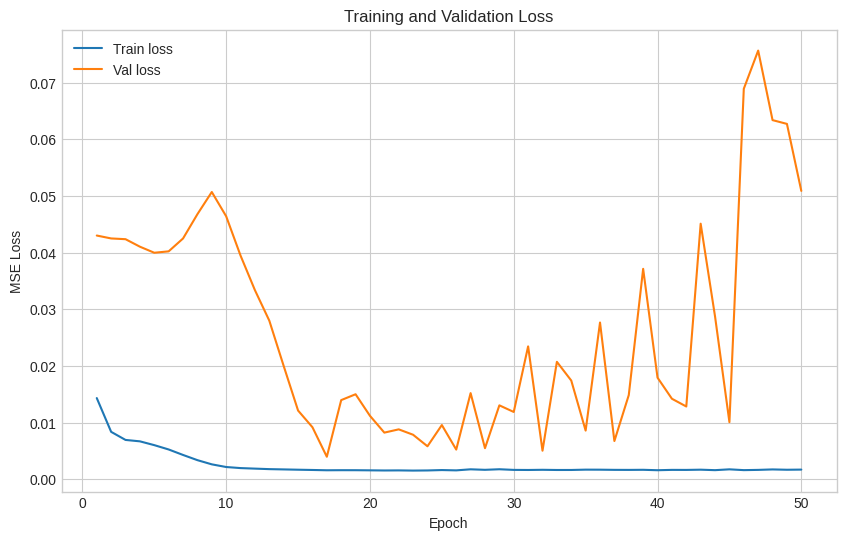

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(list(train_loss_log.keys()), list(train_loss_log.values()), label='Train loss')
plt.plot(list(val_loss_log.keys()), list(val_loss_log.values()), label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Load Model

In [27]:
best_model = min(val_loss_log, key=val_loss_log.get)
model.load_state_dict(torch.load(f'{model_save_path}//lstm_two_feature_model_{best_model}.pth', map_location=torch.device(device)))

<All keys matched successfully>

## Estimation

In [28]:
test_dataset = yf.download(tickers=tickers['ticker'], start='2020-01-01', end='2023-12-31', interval='1d')
test_data = test_dataset[['Close']]
test_data.columns = test_data.columns.droplevel(1)
test_data.columns = tickers['ticker_name']
test_data.head()

[*********************100%***********************]  2 of 2 completed


,EURUSD,S&P500
Date,,
2020-01-01,1.122083,NaN
2020-01-02,1.122083,3257.850098
2020-01-03,1.117144,3234.850098
2020-01-06,1.116196,3246.280029
2020-01-07,1.119799,3237.179932


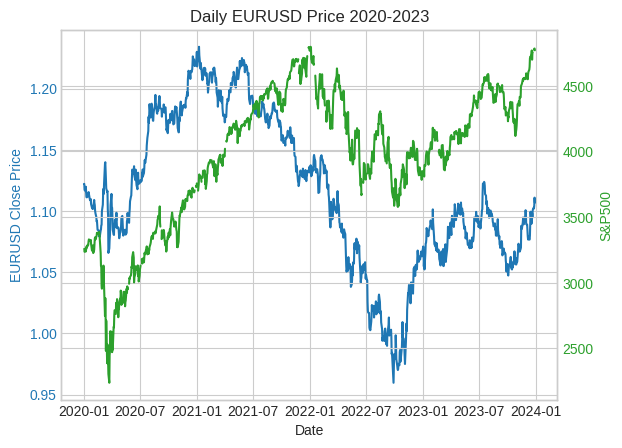

In [29]:
fig, ax1 = plt.subplots()

ax1.plot(test_data.index, test_data.EURUSD, 'tab:blue', label='EURUSD')
ax1.set_xlabel('Date')
ax1.set_ylabel('EURUSD Close Price', color='tab:blue')
ax1.tick_params('y', colors='tab:blue')

ax2 = ax1.twinx()

ax2.plot(test_data.index, test_data['S&P500'], 'tab:green', label='S&P500')
ax2.set_ylabel('S&P500', color='tab:green')
ax2.tick_params('y', colors='tab:green')

plt.title('Daily EURUSD Price 2020-2023')
plt.show()

In [30]:
# nan handling
print(test_data.isna().sum())

# fill na values with the last valid obsrvation
test_data.ffill(inplace=True)

print(f'NaN count after forward na filling: \n{test_data.isna().sum()}')

display(test_data.head())
test_data = test_data.iloc[1:, :] # remove the first row containing nan

EURUSD     0
S&P500    37
dtype: int64
NaN count after forward na filling: 
EURUSD    0
S&P500    1
dtype: int64


<ipython-input-30-508f5121f760>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.ffill(inplace=True)


,EURUSD,S&P500
Date,,
2020-01-01,1.122083,NaN
2020-01-02,1.122083,3257.850098
2020-01-03,1.117144,3234.850098
2020-01-06,1.116196,3246.280029
2020-01-07,1.119799,3237.179932


In [31]:
test_dataset, scaler = process_sequence_data(test_data, look_back=look_back, scaler=scaler, train=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [32]:
df_price.iloc[:,0:1]

,EURUSD
Date,
2012-01-03,1.294096
2012-01-04,1.305602
2012-01-05,1.293142
2012-01-06,1.279607
2012-01-09,1.268038
...,...
2019-12-24,1.109385
2019-12-25,1.109016
2019-12-26,1.109545


In [ ]:
# make predictions
y_pred_log = []
y_log = []

# scaler for eurusd
test_scaler = MinMaxScaler(feature_range=(-1,1))
test_scaler.fit(df_price.iloc[:,0:1]) # previous scaler expects two inputs

model.eval()
for batch, data in enumerate(test_loader):
  X_test, y_test = data
  X_test = X_test.to(device)
  y_test = y_test.to(device)

  y_test_pred = model(X_test)

  # import pdb; pdb.set_trace()

  # invert predictions
  y_test_pred = test_scaler.inverse_transform(y_test_pred.view(-1,1).detach().numpy()).item() # torch.Size[1] -> [1,1]
  y_test = test_scaler.inverse_transform(y_test[:,0].view(-1,1).detach().numpy()).item() # torch.Size[1,2] -> [1,1]

  y_pred_log.append(y_test_pred)
  y_log.append(y_test)

In [34]:
# compute root mean squared error, mean_absolute_error
test_rmse = math.sqrt(mean_squared_error(y_log, y_pred_log))
print(f'Test Root Mean Squared Error: {test_rmse:.4f}')
test_mae = mean_absolute_error(y_log, y_pred_log)
print(f'Test Mean Absolute Error: {test_mae: .4f}')

Test Root Mean Squared Error: 0.0399
Test Mean Absolute Error:  0.0337


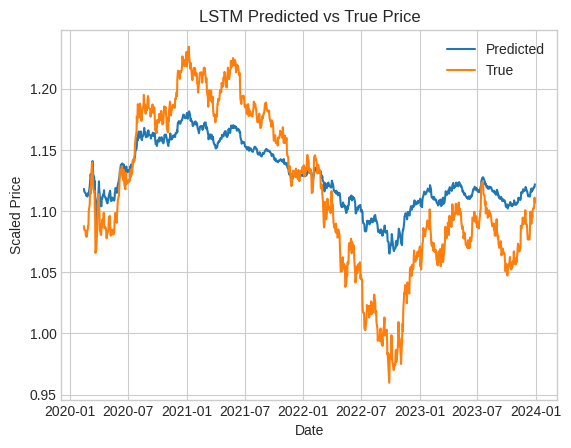

In [35]:
plt.plot(test_data.index[look_back:], y_pred_log, label='Predicted')
plt.plot(test_data.index[look_back:], y_log, label='True')
plt.xlabel('Date')
plt.ylabel('Scaled Price')
plt.title('LSTM Predicted vs True Price')
plt.legend()
plt.show()

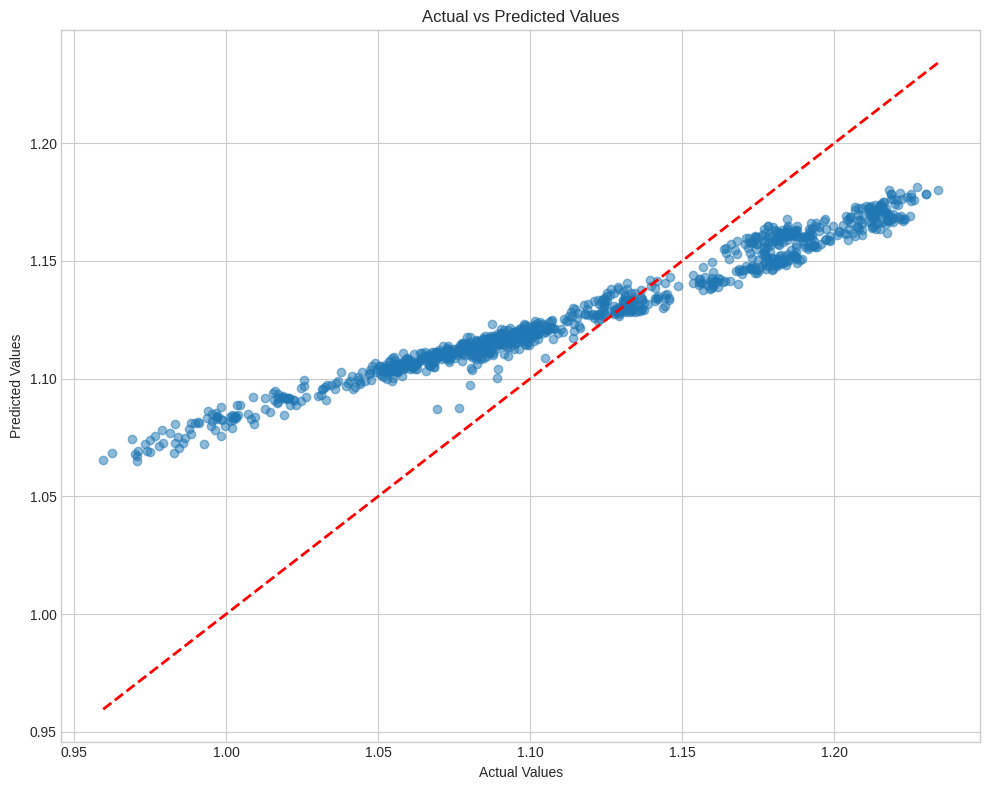

In [36]:
y_pred = np.array(y_pred_log)
y_actual = np.array(y_log)

# Create a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(y_actual, y_pred, alpha=0.5)
plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.tight_layout()
plt.show()


In [37]:
val_ic = spearmanr(y_actual, y_pred)[0]
print(f'Val IC: {val_ic:.4f}')

Val IC: 0.9853


Generally, the two-feature model can capture the price movement pattern, but it tends to overestimate price movements. Moreover, its predictive power is lower compared to the one-feature model.